In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from train import AutoencodingWorldModel, get_dataloaders, preprocess, postprocess, device, to_np
from distshift_dataset import UniqueDistshiftDataset

# Load Data

In [11]:
# world_model = AutoencodingWorldModel(.001, hidden_layers=[8, 8, 16])
world_model = AutoencodingWorldModel(.001, hidden_layers=[16, 16, 32], transition_layers=[32])
world_model.load_state_dict(torch.load(f"data/models/{world_model.model_name}_many.ckpt"))
world_model = world_model.to(device)

In [2]:
train_dataset = UniqueDistshiftDataset("distshift-v0")
test_dataset = UniqueDistshiftDataset("distshift-v1")

# Plotting Functions

In [3]:
np_to_torch = lambda np_array: torch.from_numpy(np_array).float().unsqueeze(0)
transition_to_torch = lambda s, a, r, t, ns: preprocess(np_to_torch(s), np_to_torch(a), torch.tensor([r]), torch.tensor([t]), np_to_torch(ns))

In [4]:
def plot_transition(state, action, next_state):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(state)
    axes[0].set_title(f"Action: {action}")
    axes[1].imshow(next_state)
    plt.show()

In [5]:
def plot_predicted_transitions(dataset, transition_idx):
    s, a, r, t, ns = dataset[transition_idx]
    print('true transition')
    plot_transition(s.transpose((1, 2, 0)), a, ns.transpose((1, 2, 0)))
    print('\npredicted transition')
    s, a, r, t, ns = transition_to_torch(s, a, r, t, ns)
    predictions = world_model(s, a)
    predicted_next_state = postprocess(to_np(predictions["next_state"].squeeze(0)))
    plot_transition(postprocess(to_np(s.squeeze(0))), to_np(a.squeeze(0)), predicted_next_state)

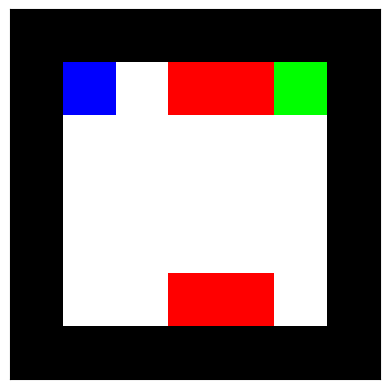

In [26]:
s = train_dataset[0][0]
s[:, 1, 5] = [0, 255, 0]
plt.imshow(s.astype(int).transpose((1, 2, 0)))
plt.xticks([])
plt.yticks([])
plt.show()

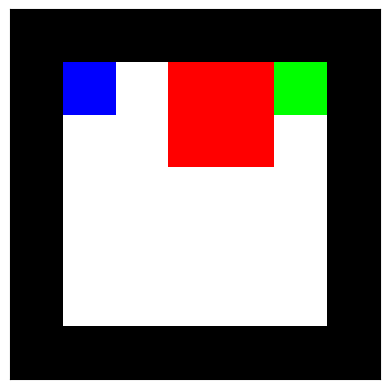

In [35]:
s = test_dataset[0][0]
s[:, 1, 5] = [0, 255, 0]
plt.imshow(s.astype(int).transpose((1, 2, 0)))
plt.xticks([])
plt.yticks([])
plt.show()

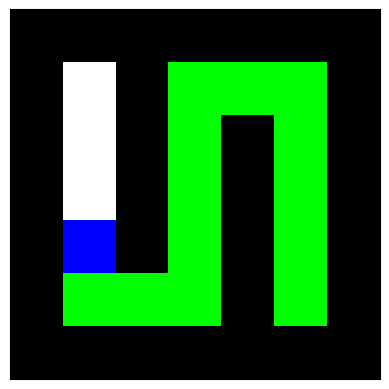

In [34]:
from maze import UnicursalBreadCrumbMaze
m = UnicursalBreadCrumbMaze(max_steps=1600, width=7, height=7) # 16 steps required to reach end of 7x7 maze
            
s = m.reset()[0]
m.step(2)
m.step(2)
s = m.step(2)[0]
# s = m.step(0)[0]
# s[:, 5, 5] = [0, 255, 0]
# for i in range(7):
#     for j in range(7):
#         if np.all(s[:, i, j] == [0, 255, 0]):
#             if (i, j) != (5, 5):
#                 s[:, i, j] = [100, 200, 100]
plt.imshow(s.astype(int).transpose((1, 2, 0)))
plt.xticks([])
plt.yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true transition


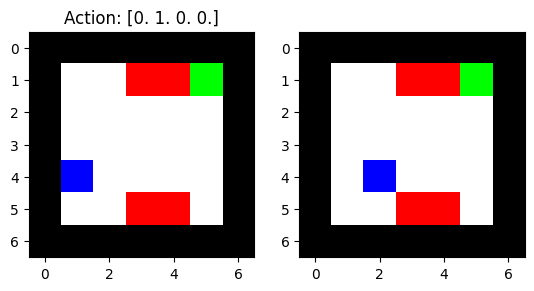


predicted transition


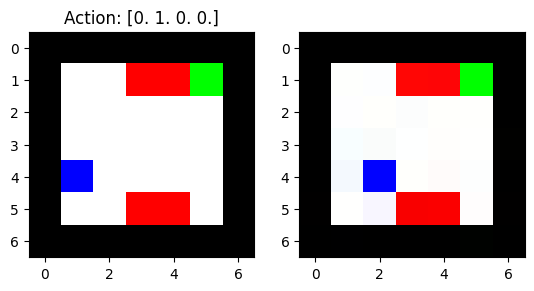

In [12]:
plot_predicted_transitions(train_dataset, 49)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true transition


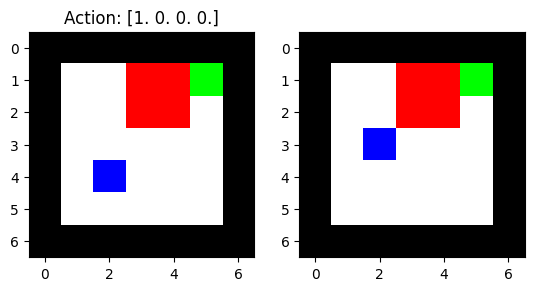


predicted transition


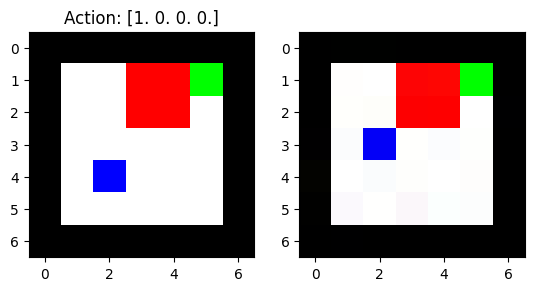

In [21]:
plot_predicted_transitions(test_dataset, 44)

In [25]:
world_model.state_encoder[0].net[0]

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))

In [11]:
c2 = torch.nn.Conv2d(2, 4, 3)

In [12]:
c2.weight.shape

torch.Size([4, 2, 3, 3])

In [19]:
c2.weight.data[0].shape

torch.Size([2, 3, 3])

In [94]:
@torch.no_grad()
def obs_acc(pred_obs, true_obs, threshold=30):
    def pp(data):
        return (data + .5) * 255
    B, C, H, W = pred_obs.shape
    obs_diff = torch.abs(pp(pred_obs) - pp(true_obs))
    obs_diff = obs_diff.sum(axis=1) < threshold
    print(obs_diff)
    return torch.mean(obs_diff.float())


def debug_agent_pos_acc():
    s, a, r, t, ns = train_dataset[15]
    
    # print('\npredicted transition')
    s, a, r, t, ns = transition_to_torch(s, a, r, t, ns)
    predictions = world_model(s, a)
    # predicted_next_state = postprocess(to_np(predictions["next_state"].squeeze(0)))
    print(obs_acc(predictions["next_state"], ns))
    
    
debug_agent_pos_acc()

tensor([[[ True,  True,  True,  True,  True,  True,  True],
         [ True, False,  True,  True,  True,  True,  True],
         [ True, False, False,  True,  True,  True,  True],
         [ True, False, False,  True,  True,  True,  True],
         [ True, False, False,  True,  True,  True,  True],
         [ True, False,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True]]], device='cuda:0')
tensor(0.8367, device='cuda:0')
